In [1]:
import tensorflow as tf
# current processing

# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))


# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             print(gpu)
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import models, layers
from keras.models import Sequential
from keras.layers import preprocessing
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

from PIL import Image, ImageChops, ImageEnhance
import itertools
import os
import random

import time
import itertools
import shutil
import cv2
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

dataset = 'CASIA1'
pathfinal = path + f'model_history/{dataset}/'
pathfinal2 = path + 'model_images/'

dir = f'{path + dataset}'
interval = 3
epoch = 10

casio2_data =  path+'CASIA2_processed_data'
casio1_data =  path+'CASIA1_processed_data'

global_random_state = 42
image_size = (224, 224)
np.random.seed(global_random_state)
checkpoint_path = ''

In [3]:
def convert_to_ELA_image(image):
        quality=90
        #im=image.convert('RGB')
        im = Image.fromarray(image,'RGB')
        im.save('resaved.jpg','JPEG', quality=quality)
        resaved_im=Image.open('resaved.jpg')
        ela_im = ImageChops.difference(im, resaved_im)
        os.remove('resaved.jpg')
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0/max_diff 
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        resaved_im.close()
        return np.array(ela_im,dtype='float64')

In [4]:
# Define the directory where your images are located
image_directory = 'CASIA1'

# Create an ImageDataGenerator with rescaling
# datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)  # 20% for validation
datagen = ImageDataGenerator(
    preprocessing_function=convert_to_ELA_image,
      rescale=1./255,
    #   rotation_range=40,
    #   width_shift_range=0.2,
    #   height_shift_range=0.2,
    #   shear_range=0.2,
    #   zoom_range=0.2,
    #   horizontal_flip=True,
      validation_split=0.2)

# Set the desired image size
image_size = (224, 224)
batch_size = 32
# Create a data generator for training data
train_generator = datagen.flow_from_directory(
    image_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify that this is the training subset
)

# Create a data generator for validation data
validation_generator = datagen.flow_from_directory(
    image_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify that this is the validation subset
)

# Now you have separate data generators for training and validation data
# The data is automatically split based on the validation_split parameter


Found 1377 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Total number of parameters: 105826


2023-09-16 23:54:56.028033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-16 23:54:56.028183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


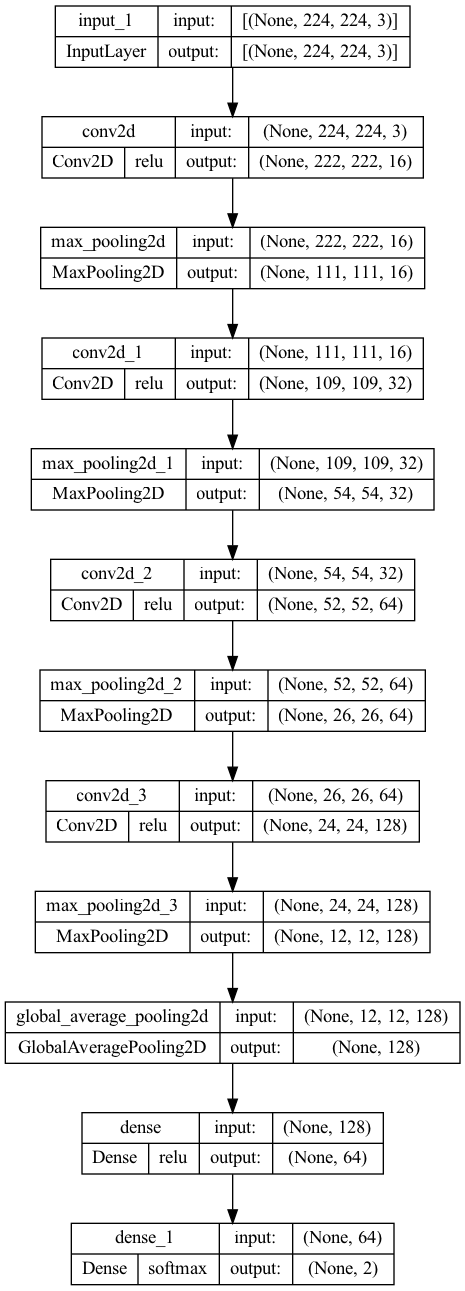

In [5]:
# Define the model
def build_model():
    model = Sequential()

    # Stage 1: Preprocessing (Resize image)
    # You can add a preprocessing layer to resize the input image to the desired size
    model.add(layers.Input(shape=(224, 224, 3)))  # Adjust the input shape as needed

    # Stage 2: Feature Extraction
    # First Convolutional Layer
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())

    # Stage 3: Classification
    # Fully Connected Layer
    model.add(layers.Dense(64, activation='relu')) # added
    model.add(layers.Dense(2, activation='softmax')) # 2 classes (authentic or forgery)

    return model

model = build_model()
# model.summary()
total_parameters = model.count_params()
print(f"Total number of parameters: {total_parameters}")
plot_model(model,to_file=f'{pathfinal2}/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

In [6]:
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epoch)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Evaluate the model initial losses
# initial_train_loss, initial_train_acc = model.evaluate(X_train, Y_train, verbose=0)
# initial_valid_loss, initial_valid_acc = model.evaluate(X_val, Y_val, verbose=0)

In [7]:
# Fit the model
hist = model.fit(train_generator,
                        batch_size = batch_size,
                        epochs=epoch,
                        validation_data=validation_generator,
                        # callbacks=[model_saver, 
                                #    HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc), interval), 
                                #    early_stopping_cb],
                        verbose=1)

df_history = pd.DataFrame(hist.history)

Epoch 1/10


2023-09-16 23:54:57.262395: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-16 23:54:57.549282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5229

2023-09-16 23:55:03.639678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 8s 162ms/step - loss: 0.6920 - accuracy: 0.5229 - val_loss: 0.6910 - val_accuracy: 0.5349
Epoch 2/10
44/44 [==============================] - 7s 152ms/step - loss: 0.6921 - accuracy: 0.5352 - val_loss: 0.6916 - val_accuracy: 0.5349
Epoch 3/10
44/44 [==============================] - 7s 157ms/step - loss: 0.6918 - accuracy: 0.5352 - val_loss: 0.6901 - val_accuracy: 0.5349
Epoch 4/10
44/44 [==============================] - 7s 153ms/step - loss: 0.6913 - accuracy: 0.5352 - val_loss: 0.6903 - val_accuracy: 0.5349
Epoch 5/10
44/44 [==============================] - 6s 146ms/step - loss: 0.6903 - accuracy: 0.5352 - val_loss: 0.6899 - val_accuracy: 0.5349
Epoch 6/10
44/44 [==============================] - 6s 141ms/step - loss: 0.6902 - accuracy: 0.5352 - val_loss: 0.6899 - val_accuracy: 0.5349
Epoch 7/10
44/44 [==============================] - 7s 147ms/step - loss: 0.6903 - accuracy: 0.5352 - val_loss: 0.6895 - val_accuracy: 0.5349
Epoch 8/10
44/44 